In [114]:
# %load_ext rpy2.ipython
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn import decomposition, mixture
from scipy.stats import ttest_ind
from clustergram import Clustergram
from sklearn.model_selection import train_test_split
import warnings
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import decomposition
import numpy.linalg as la
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)

# Part 1

## Data Pre-processing

Reading in files.

In [2]:
control = pd.read_csv('Control_Data.csv') 
exposed = pd.read_csv('Exposed_Data.csv')
data_dictionary = pd.read_csv('data_dictionary.csv')


In [3]:
exposed['exposed'] = 1
control['exposed'] = 0
df = pd.concat([exposed, control], ignore_index = True)
df['urbanicity'] = df['urbanicity'].replace({'S': 'Suburban',
                                             'U': 'Urban',
                                             'R': 'Rural'})

Data cleaning

In [4]:
df.dropna(axis='columns', thresh= 1600) #drop columns with too many NA
# Find the fill rate of each Individual blu ID (row)
df['Fill_Rate'] = df.sum(axis = 1) / df.shape[1]
indexNames_low_fill_ind = df[df['Fill_Rate'] < .70].index
# Deleting Individuals (rows) from data frame with low fill rates.
df.drop(indexNames_low_fill_ind, inplace=True)
#fill missing values
df.drop(columns = ['Fill_Rate'], inplace=True)

In [5]:
cat = df.columns[df.dtypes=='object']
df = pd.get_dummies(df, columns=cat) # change categorical into dummy variables
factors = ['zip11', 'cbsa_code', 'census_tract', 'census_block_id', 'census_block_group', 'msa'] #Removing redundant features-- these are all correlated with each other.
df = df.drop(columns = factors) 
df = df.drop(columns=['gender_U']) 

In [7]:
# Filter out binary dummy variables from the DataFrame to get only numeric variables, fill missing values
dummy_mask = df.apply(lambda col: set(col.unique()) == {0, 1})
non_dummy_columns = df.columns[~dummy_mask]
dummy_data = df.columns[dummy_mask]
dummy_data = df[dummy_data]
filtered_data = df[non_dummy_columns]

In [67]:
mean_values = df[non_dummy_columns].mean()
df[non_dummy_columns] = df[non_dummy_columns].fillna(mean_values)
#df.isnull().sum().value_count(sort_ascending = False)

df_control = df.loc[df['exposed'] == 0,]
df_exposed = df.loc[df['exposed'] == 1,]

## Demographics of the samples

Age and Income

In [68]:
df['exposed'].value_counts()

1    996
0    988
Name: exposed, dtype: int64

age
exposed_Mean: 51.345382
exposed_Median: 52.000000
control_Mean: 53.486294
control_Median: 54.000000

income
exposed_Mean: 72504.115226
exposed_Median: 62000.000000
control_Mean: 75236.536431
control_Median: 52000.000000



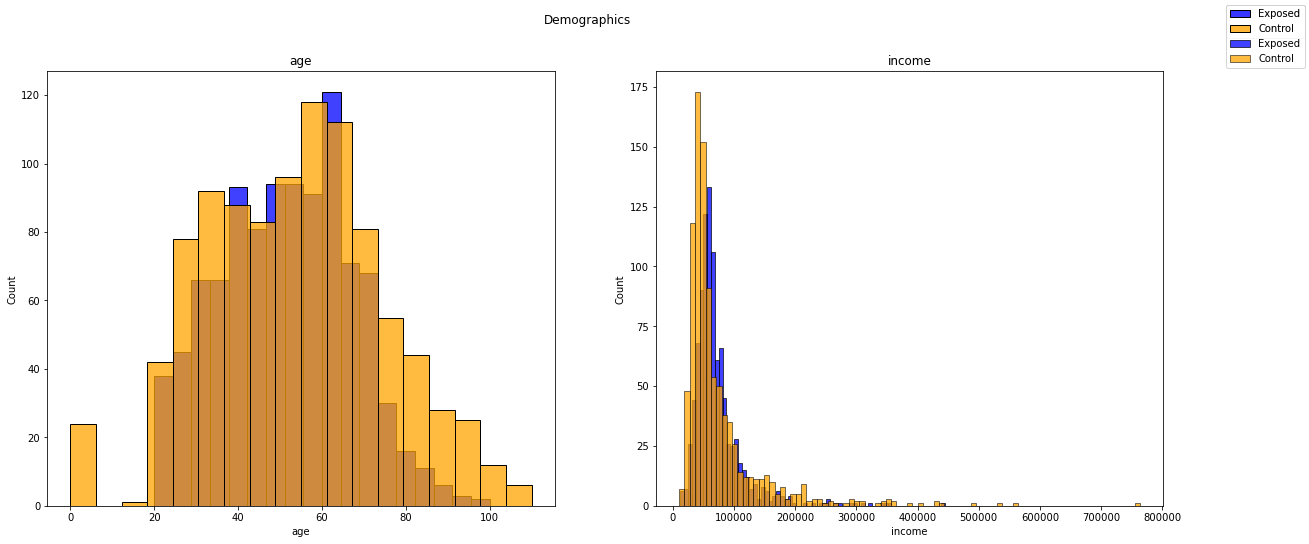

In [69]:
num = ['age', 'income']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Demographics')

# Plot
for i in range(len(num)):
    axes[i].set_title(num[i])
    sns.histplot(exposed[num[i]], ax=axes[i], color="blue", label="Exposed")
    sns.histplot(control[num[i]], ax=axes[i], color="orange", label="Control")
    fig.legend()
    print(num[i])
    print("exposed_Mean: %f" % exposed[num[i]].mean())
    print("exposed_Median: %f" % exposed[num[i]].median())
    print("control_Mean: %f" % control[num[i]].mean())
    print("control_Median: %f" % control[num[i]].median())
    print()

Education

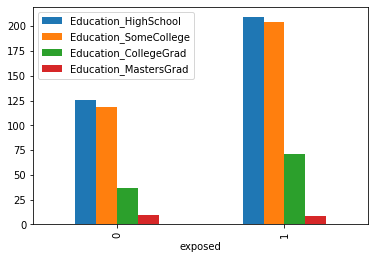

In [70]:
labs = {'edu100': 'Education_HighSchool', 
        'edu101': 'Education_SomeCollege', 
        'edu102': 'Education_CollegeGrad',
        'edu103': 'Education_MastersGrad'}
df = df.rename(columns = labs)
edu_list = [i for i in labs.values()]
education = df.groupby('exposed')[edu_list].sum().plot(kind='bar')


Gender

<AxesSubplot:xlabel='exposed'>

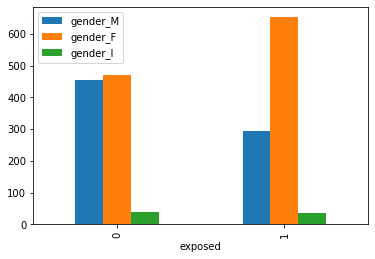

In [71]:
gender_list = ['gender_M', 'gender_F', 'gender_I']
gender = df.groupby('exposed')[gender_list].sum().plot(kind='bar')
gender

### Comparing means to find largest differences between the exposed and control group

In [72]:
def find_variables_with_largest_differences(dataset1, dataset2, num_top_variables=10):
    # Step 2: Calculate Differences
    differences = {}
    for column in dataset1.columns:
        if dataset1[column].nunique() == 2 and dataset2[column].nunique() == 2:
            proportion_dataset1 = dataset1[column].mean()
            proportion_dataset2 = dataset2[column].mean()
            absolute_difference = abs(proportion_dataset1 - proportion_dataset2)
            differences[column] = {
                'dataset1_mean': proportion_dataset1,
                'dataset2_mean': proportion_dataset2,
                'absolute_difference': absolute_difference
            }

    # Step 3: Sort and Select Top Variables
    sorted_differences = sorted(differences.items(), key=lambda x: x[1]['absolute_difference'], reverse=True)
    top_variables = [item[0] for item in sorted_differences[:num_top_variables]]
    top_variables_info = {item[0]: item[1] for item in sorted_differences[:num_top_variables]}

    return top_variables, top_variables_info

What are the top attributes that make the Treatment Group different from the Control group?

In [81]:
num_top_variables = 10
top_variables, top_variables_info = find_variables_with_largest_differences(df_control, df_exposed, num_top_variables)
data_dictionary['column_name'] = data_dictionary['column_name'].str.lower()
top_variables = pd.Series(top_variables, name = 'top_variables')
merged_dictionary = data_dictionary.merge(top_variables, left_on='column_name', right_on='top_variables', how='inner')

In [80]:
for variable in top_variables:
    print(data_dictionary[data_dictionary['column_name']==variable]['attribute_name'].item())
    print(f"Control Mean: {top_variables_info[variable]['dataset1_mean']:.3f}")
    print(f"Exposed Mean: {top_variables_info[variable]['dataset2_mean']:.3f}")
    print(f"Absolute Difference: {top_variables_info[variable]['absolute_difference']:.3f}")
    print()

High # of Active Retail Cards
Control Mean: 0.381
Exposed Mean: 0.719
Absolute Difference: 0.338

0 Children in Household
Control Mean: 0.376
Exposed Mean: 0.082
Absolute Difference: 0.293

Cooking
Control Mean: 0.385
Exposed Mean: 0.655
Absolute Difference: 0.270

Gourmet Cooking
Control Mean: 0.354
Exposed Mean: 0.616
Absolute Difference: 0.262

Children in Household - All Ages
Control Mean: 0.372
Exposed Mean: 0.620
Absolute Difference: 0.248

Hobbyists
Control Mean: 0.335
Exposed Mean: 0.581
Absolute Difference: 0.246

Avid Reader
Control Mean: 0.440
Exposed Mean: 0.686
Absolute Difference: 0.245

Food
Control Mean: 0.310
Exposed Mean: 0.548
Absolute Difference: 0.238

Crafts
Control Mean: 0.324
Exposed Mean: 0.559
Absolute Difference: 0.235

Travel
Control Mean: 0.431
Exposed Mean: 0.666
Absolute Difference: 0.234



## Conducting factor analysis to reduce dimensions before clustering.

In [82]:
# Standardize all variables except dummy variables.
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df[non_dummy_columns]), columns=filtered_data.columns)

In [83]:
## Set the data to a matrix
TD = np.array(data_scaled)

In [84]:
pca = decomposition.PCA() ## create the function
XTrans = pca.fit_transform(data_scaled) ## apply PCA on data set
print(pca.explained_variance_ratio_) ## get the percent explained for each PC

[2.59147778e-01 7.03079389e-02 4.88054637e-02 4.59532651e-02
 3.60354922e-02 3.20938264e-02 2.72571231e-02 2.47353085e-02
 2.31737982e-02 2.06731428e-02 2.01747316e-02 1.86098614e-02
 1.83649173e-02 1.82078482e-02 1.76068787e-02 1.74403898e-02
 1.70253167e-02 1.69586679e-02 1.64766226e-02 1.53527273e-02
 1.49261481e-02 1.43985518e-02 1.40790902e-02 1.29520015e-02
 1.28907221e-02 1.27513465e-02 1.21537450e-02 1.17484800e-02
 1.10080074e-02 9.85039762e-03 9.08045469e-03 8.97247308e-03
 8.72968673e-03 8.40426459e-03 8.00219849e-03 7.67218382e-03
 7.19951579e-03 6.70718876e-03 6.09977087e-03 5.67119857e-03
 4.72652745e-03 4.26908645e-03 4.13321194e-03 3.89846558e-03
 3.35700892e-03 2.98682854e-03 2.15797639e-03 1.55836208e-03
 1.17227706e-03 1.06053079e-03 8.94330086e-04 7.10013320e-04
 5.43798841e-04 4.45853961e-04 2.46912531e-04 1.40292143e-04
 1.78656906e-33]


#### Examining the Explained Variance Ratio 

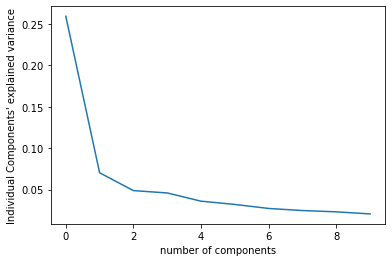

In [85]:
# Displaying the individual contribution of each component
plt.plot((pca.explained_variance_ratio_[0:10]))
plt.xlabel('number of components')
plt.ylabel("Individual Components' explained variance")
plt.show()

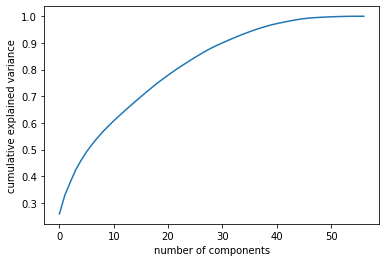

In [86]:
# Displaying the combined contribution of the components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [87]:
# choose the number of components you would like to include: 
numDimensions = 30
pct_of_data_explained = round(sum(pca.explained_variance_ratio_[0:numDimensions]),2)*100
print(f"Having {numDimensions} components will explain {pct_of_data_explained}% of the data") 

Having 30 components will explain 89.0% of the data


In [100]:
#Create New Dataframe
loadings = XTrans[:,:(29)]
loadings = pd.DataFrame(loadings)
email_signup_label = df['exposed']
loadings = pd.merge(loadings, email_signup_label, left_index=True, right_index=True)
loadings.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,exposed
count,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000
mean,0.020188,-0.006411,-0.000435,-0.000767,0.000112,-0.004517,-0.000476,0.000630,0.001423,0.000976,-0.000677,0.001181,0.002013,0.001375,0.001308,-0.000054,-0.000871,-0.000918,-0.000025,0.001936,-0.000382,0.000179,-0.001496,-0.001122,0.001134,-0.002989,0.000056,-0.000687,0.000681,0.506098
std,3.795041,1.979711,1.653424,1.606590,1.424985,1.342123,1.237044,1.177419,1.141266,1.078841,1.065421,1.022902,1.013721,1.009988,0.994362,0.990919,0.978560,0.975532,0.963354,0.928447,0.915786,0.901127,0.889004,0.853000,0.848140,0.843287,0.827863,0.812912,0.786392,0.500090
min,-8.652554,-6.295474,-4.590535,-5.662046,-6.672319,-6.240684,-4.715770,-5.109187,-5.498292,-5.869003,-3.479859,-4.842118,-4.711962,-4.595647,-10.525113,-5.416322,-6.862274,-7.060823,-9.335427,-4.666476,-3.794622,-5.645264,-4.747662,-5.881582,-3.287643,-3.227183,-3.872631,-3.585953,-6.275908,0.000000
25%,-0.086208,-1.088592,-0.941389,-0.880815,-0.583869,-0.691833,-0.601068,-0.625726,-0.497202,-0.508139,-0.532606,-0.345167,-0.501052,-0.544269,-0.389112,-0.516662,-0.352843,-0.371378,-0.423590,-0.463277,-0.558093,-0.403296,-0.553345,-0.427172,-0.405304,-0.421863,-0.356803,-0.431323,-0.295835,0.000000
50%,0.820372,-0.134953,-0.139657,-0.149961,-0.072530,-0.126672,-0.048180,0.127321,0.004421,0.040051,-0.101453,-0.007569,-0.020113,-0.004751,0.014251,-0.031785,0.001671,0.030038,0.027154,0.023225,-0.051856,0.029230,-0.015983,-0.030236,-0.004963,-0.011745,-0.014721,-0.030508,0.008674,1.000000
75%,2.649862,1.080787,0.480995,0.777502,0.564906,0.625943,0.524551,0.732339,0.374687,0.464205,0.353757,0.367654,0.364957,0.494323,0.327367,0.445427,0.339809,0.429878,0.357555,0.462769,0.491504,0.443529,0.562307,0.396166,0.416195,0.395278,0.381189,0.385880,0.263144,1.000000
max,10.006810,7.840192,10.625450,12.168200,8.218359,10.292963,5.761268,6.287181,10.004665,9.986785,16.898351,8.059143,16.775811,15.233395,18.851009,20.136226,10.186685,16.166198,10.241827,5.892596,6.669836,7.566023,6.291053,6.782197,10.107809,5.277378,4.985655,6.312015,6.361631,1.000000


We are looking to segment the Treatment and Control groups using their attributes. Using Cluster analysis:
- Recommend the appropriate number of clusters: 2 (treatment and control group).
- Explain the similarity measure you applied: I used the Ward criterion which aims to minimize the variance between points within the cluster.

I'll use the loadings from the factor analysis to do cluster analysis.

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.2870206832885742 seconds.
K=3 fitted in 0.5054562091827393 seconds.
K=4 fitted in 0.9977576732635498 seconds.
K=5 fitted in 0.7922134399414062 seconds.
K=6 fitted in 1.4988362789154053 seconds.
K=7 fitted in 0.8958070278167725 seconds.
K=8 fitted in 1.0943305492401123 seconds.
K=9 fitted in 1.310727834701538 seconds.


<AxesSubplot:xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

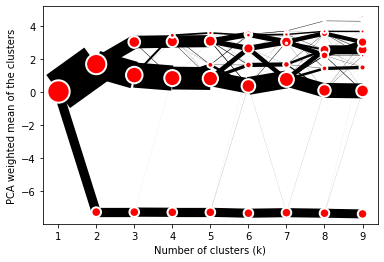

In [102]:
# this will show you the differences between clusters 
# and how much of the data is in each cluster
cgram = Clustergram(range(1, 10))
cgram.fit(loadings)
cgram.plot()

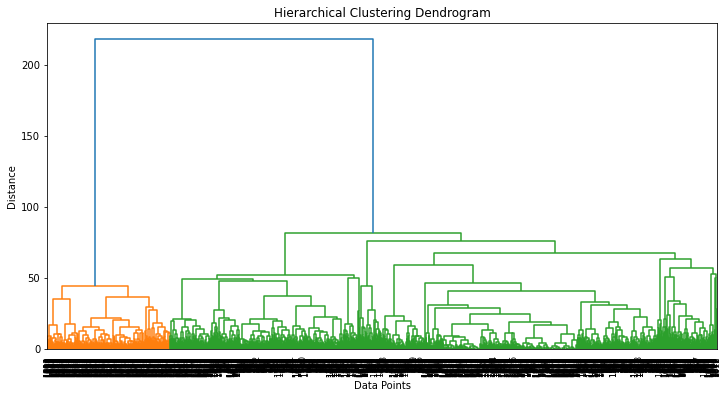

In [103]:
Z = linkage(loadings, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [104]:
def agglomerative_fn(data, n_clusters=2):
    model = AgglomerativeClustering(n_clusters = n_clusters).fit(data)
    
    return model

- Interpret, describe, and validate the cluster - The algorithm I used is based on the idea that points (people) are connected to other people with similar traits rather than people with dissimilar traits, so it starts by putting everybody in a separate cluster and then iteratively places similar people together until everyone is in 2 clusters. 

Unfortunately, the cluster evaluation scores below show that the clusters don't do a great job of labeling the treatment and control "cluster" that a person is in. I tried a couple of other clustering methods like K-means but also got bad scores-- this is probably just due to the nature of the data, although it would be possible if I had more time to try more data cleaning/transformation methods to improve the read.

In [105]:
def build_model(clustering_model, data, labels):
    
    model = clustering_model(data)

    print('homo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print(50 * '-')
    
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          %(metrics.homogeneity_score(labels, model.labels_),
            metrics.completeness_score(labels, model.labels_),
            metrics.v_measure_score(labels, model.labels_),
            metrics.adjusted_rand_score(labels, model.labels_),
            metrics.adjusted_mutual_info_score(labels,  model.labels_),
            metrics.silhouette_score(data, model.labels_)))

In [107]:
labels = loadings['exposed']
build_model(agglomerative_fn, loadings, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.217	0.316	0.258	0.143	0.257	0.331


# Part 2

In this part of the assignment you are free to use any statistical technique that can help you explain the outcome / response metric from the Treatment group compared to the Control group. You can use logistic regression, propensity score analysis and matching and/or any other technique. The response metric from the Treatment Group is an “Email SignUp”.

In [115]:
# Create Train and Test data 
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['exposed']),df['exposed'],test_size=0.25,random_state=0) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape,y_train.sum(),y_test.sum()
X_train_sample = X_train
X_test_sample = X_test

y_train_sample = y_train
y_test_sample = y_test

In [116]:
############# LogReg
LRclf = LogisticRegression(solver = 'newton-cg', class_weight = 'auto')
LRclf.fit(X_train_sample, y_train_sample)

LogisticRegression(class_weight='auto', solver='newton-cg')

In [117]:
lr_features = LRclf.coef_[0]
cols = X_train.columns.values

In [124]:
# Create a dataframe with features
features_dataframe = pd.DataFrame( {'LR feature importances': lr_features})
features_dataframe.set_index(cols, drop=True, inplace=True, verify_integrity = True)
fet_vars = [var for var in features_dataframe.columns ]

# create scaler
scaler = MinMaxScaler(feature_range=(1, 100))
#  fit  the scaler to the train set
scaler.fit(features_dataframe[fet_vars]) 
# transform the train and test set
features_dataframe[fet_vars] = scaler.transform(features_dataframe[fet_vars])

What are the variables explaining the differences between the Treatment and the Control group?
- Treatment Group is more likely to have Lowest Average credit card balance= True (CHC13).
- Treatment Group is more likely to be in lower numbered Congressional Districts (~1-10).
- Treatment Group is more likely to be Female.
- Treatment Group is more likely to like walking.
- Treatment group is more likely to own a cat.
- Treatment group is more likely to purchase home furnishings.


<BarContainer object of 37 artists>

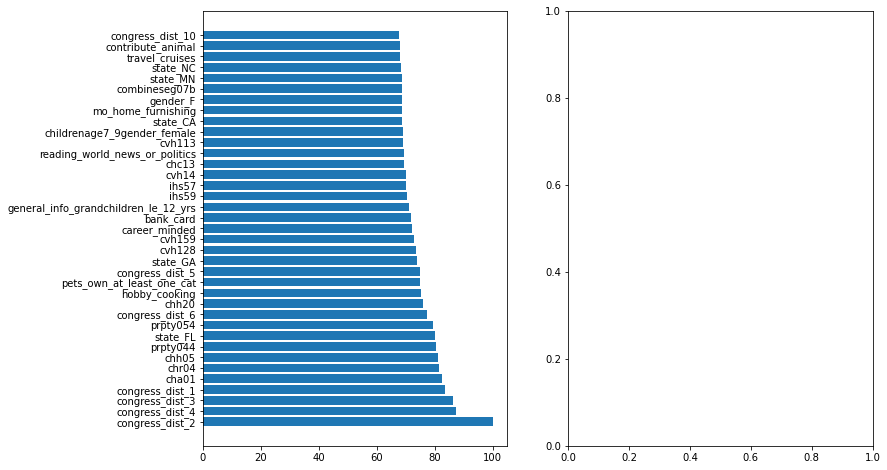

In [125]:
features_dataframe.T.mean().sort_values(ascending=False)[:37].to_csv('key_features_email_signup.csv')
key_features = features_dataframe.T.mean().sort_values(ascending=False)[:37]
key_features=key_features.drop(index=[])
features_dataframe = features_dataframe.T[key_features.index]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(features_dataframe.columns, features_dataframe.mean())

Did you train your model? Explain - Yes, I trained the logistic regression model to improve classification.

In [126]:
predtrn=LRclf.predict_proba(X_train)[:,1]
y_test_predict=LRclf.predict_proba(X_test)[:,1]
features_dataframe.T.mean().sort_values(ascending=False)[:25]
y_train_pred = np.where(predtrn >= 0.006, 1, 0)
y_test_pred = np.where(y_test_predict >= 0.006, 1, 0)
cm_train = confusion_matrix(y_train_sample, y_train_pred)
cm_test = confusion_matrix(y_test_sample, y_test_pred)

In [127]:
# AUC Score
roc_auc_score(y_test_sample, y_test_predict),roc_auc_score(y_train_sample, predtrn)

(0.9888617886178862, 0.9998789521228546)

In [128]:
print(cm_train)
print(cm_test)
print('Train Accuracy' + str(accuracy_score(y_train, y_train_pred)))
print('Test Accuracy' + str(accuracy_score(y_test, y_test_pred)))

[[478 260]
 [  0 750]]
[[162  88]
 [  0 246]]
Train Accuracy0.8252688172043011
Test Accuracy0.8225806451612904
